# PIQT Images from Southmead

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

from mriqa.phantoms import phantom_mask_2d, find_phantom, SIEMENSLONGBOTTLE
from mriqa.dcmio import (
    fetch_series, rx_coil_name, approx_slice_orientation,
    approx_phase_orientation, series_number, seq_name, protocol_name,
    pix_spacing_yx
)
from mriqa.reports import snr_report, ghosting_report, uniformity_report
from mriqa.tools import mean_im, diff_im
from dcmextras.siemenscsa import csa, phoenix
import pandas as pd
import warnings

In [2]:
from glob import glob
from os.path import join
from pydicom import dcmread

In [3]:
fname = join('13466700-1-101-AS-HEADTS', 'MR.0001.dcm')
d = dcmread(fname)

print(len(d.SharedFunctionalGroupsSequence))
d.SharedFunctionalGroupsSequence[0]

1


(0018, 9006)  MR Imaging Modifier Sequence  1 item(s) ---- 
   (0018, 0095) Pixel Bandwidth                     DS: '288.91714477539'
   (0018, 9020) Magnetization Transfer              CS: 'NONE'
   (0018, 9022) Blood Signal Nulling                CS: 'NO'
   (0018, 9028) Tagging                             CS: 'NONE'
   (0018, 9098) Transmitter Frequency               FD: 127.742496
   ---------
(0018, 9042)  MR Receive Coil Sequence  1 item(s) ---- 
   (0018, 1250) Receive Coil Name                   SH: 'MULTI COIL'
   (0018, 9041) Receive Coil Manufacturer Name      LO: ''
   (0018, 9043) Receive Coil Type                   CS: 'MULTICOIL'
   (0018, 9044) Quadrature Receive Coil             CS: 'NO'
   (0018, 9045)  Multi-Coil Definition Sequence  1 item(s) ---- 
      (0018, 9047) Multi-Coil Element Name             SH: 'MULTI ELEMENT'
      (0018, 9048) Multi-Coil Element Used             CS: 'YES'
      ---------
   ---------
(0018, 9049)  MR Transmit Coil Sequence  1 item(s) -

In [4]:
print(len(d.PerFrameFunctionalGroupsSequence))
d.PerFrameFunctionalGroupsSequence[0]

1


(0018, 9114)  MR Echo Sequence  1 item(s) ---- 
   (0018, 9082) Effective Echo Time                 FD: 4.323
   ---------
(0018, 9152)  MR Metabolite Map Sequence  1 item(s) ---- 
   (0018, 9080) Metabolite Map Description          ST: 'WATER'
   ---------
(0018, 9226)  MR Image Frame Type Sequence  1 item(s) ---- 
   (0008, 9007) Frame Type                          CS: ['ORIGINAL', 'PRIMARY', 'T1', 'NONE']
   (0008, 9205) Pixel Presentation                  CS: 'MONOCHROME'
   (0008, 9206) Volumetric Properties               CS: 'VOLUME'
   (0008, 9207) Volume Based Calculation Technique  CS: 'NONE'
   (0008, 9208) Complex Image Component             CS: 'MAGNITUDE'
   (0008, 9209) Acquisition Contrast                CS: 'T1'
   ---------
(0020, 9111)  Frame Content Sequence  1 item(s) ---- 
   (0018, 9074) Frame Acquisition DateTime          DT: '20170130163920.77'
   (0018, 9151) Frame Reference DateTime            DT: '20170130163911.36000'
   (0018, 9220) Frame Acquisition Durati

In [5]:
T_E = d.PerFrameFunctionalGroupsSequence[0].MREchoSequence[0].EffectiveEchoTime
T_E

4.323

In [6]:
fnames = sorted(glob(join('13466700-1*', 'MR.0001.dcm')))
dobjs = [dcmread(fname) for fname in fnames]
images = [dobj.pixel_array for dobj in dobjs]

for image, fname in zip(images, fnames):
    print('Image', fname, 'has', image.ndim, 'dimensions')

Image 13466700-1-101-AS-HEADTS/MR.0001.dcm has 2 dimensions
Image 13466700-1-201-AS-HEADTS/MR.0001.dcm has 2 dimensions
Image 13466700-1-301-AS-HEADTT/MR.0001.dcm has 2 dimensions
Image 13466700-1-501-QA1H-MS-SE/MR.0001.dcm has 3 dimensions
Image 13466700-1-601-QA2H-MS-FE/MR.0001.dcm has 3 dimensions
Image 13466700-1-701-QA3B-2D-SE/MR.0001.dcm has 3 dimensions


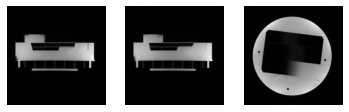

In [7]:
fig, axs = plt.subplots(1, 3)
for image, ax in zip(images[:3], axs.flat):
    ax.imshow(image, cmap='gray')
    ax.grid(False)
    ax.axis('off')

0 4095


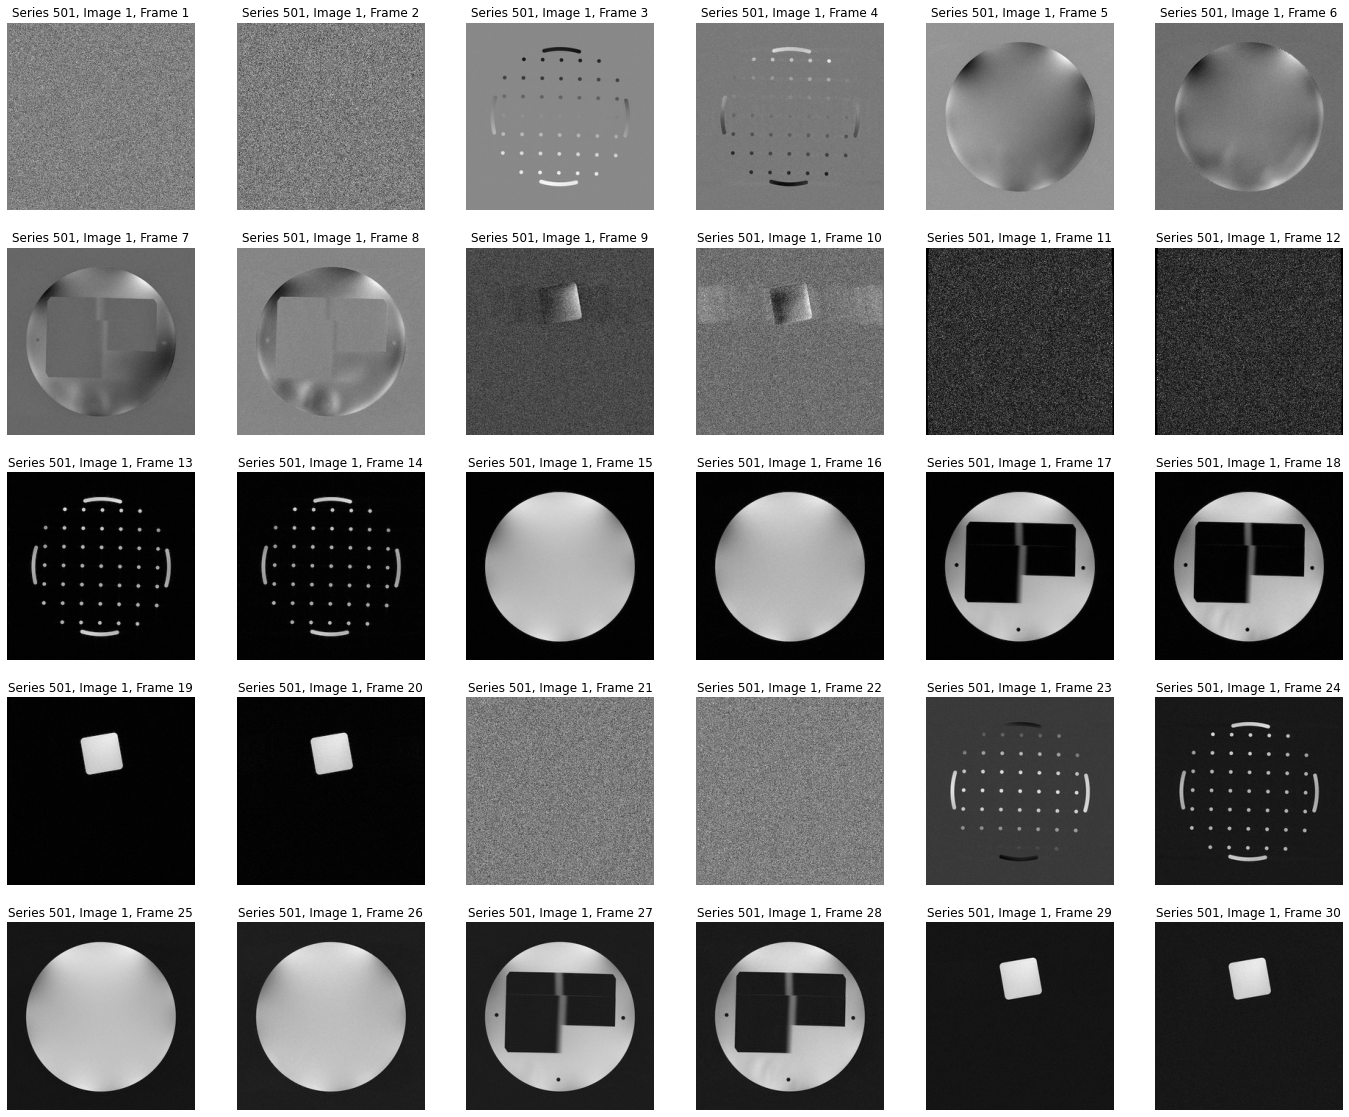

In [8]:
from mriqa.tools import show_mosaic
print(np.min(images[3]), np.max(images[3]))
show_mosaic(dobjs[3:4])

In [9]:
import xarray as xa

In [10]:
print('Contrast:  ', dobjs[3].AcquisitionContrast)
print('Type:      ', dobjs[3].MRAcquisitionType)
print('Spacing:   ', dobjs[3].SpacingBetweenSlices, 'mm')
print('Bandwidth: ', dobjs[3].PixelBandwidth, 'Hz/pixel')
print('Num Echos: ', dobjs[3].EchoTrainLength)
print('Sequence:  ', dobjs[3].PulseSequenceName)
print('TX Coil:   ', dobjs[3].TransmitCoilType, '(!!)')
print('Part.Four.:', dobjs[3].PartialFourier)

print('Bits Allo: ', dobjs[3].BitsAllocated)
print('Bits Stor: ', dobjs[3].BitsStored)

print('Image Mask:',
     hex(
         ((2 ** dobjs[3].BitsAllocated) - 1) >> (dobjs[3].BitsAllocated - dobjs[3].BitsStored)
     )
)
print('Pix Repr:  ', 'Unsigned' if dobjs[3].PixelRepresentation == 0 else 'Signed')
print('Min Value: ', dobjs[3].pixel_array.min())
print('Max Value: ', dobjs[3].pixel_array.max())

# print('Echos:     ', dobjs[3].NumberOfEchoes) # private
# print('Slices:    ', dobjs[3].NumberOfSlicesMR) # private

print('RX Coil:   ', dobjs[3].SharedFunctionalGroupsSequence[0].MRReceiveCoilSequence[0].ReceiveCoilName)
print('TR:        ', dobjs[3].SharedFunctionalGroupsSequence[0].MRTimingAndRelatedParametersSequence[0].RepetitionTime, 'ms')
print('Flip Angle:', dobjs[3].SharedFunctionalGroupsSequence[0].MRTimingAndRelatedParametersSequence[0].FlipAngle, 'degrees')

print('Fat Sat:   ', dobjs[3].SharedFunctionalGroupsSequence[0].MRModifierSequence[0].SpectrallySelectedExcitation)
print('Phase Enc: ', dobjs[3].SharedFunctionalGroupsSequence[0].MRFOVGeometrySequence[0].InPlanePhaseEncodingDirection)

print('Echo Time: ', dobjs[3].PerFrameFunctionalGroupsSequence[0].MREchoSequence[0].EffectiveEchoTime)
print('Image Type:', dobjs[3].PerFrameFunctionalGroupsSequence[0].MRImageFrameTypeSequence[0].ComplexImageComponent)
print('Index Vals:', dobjs[3].PerFrameFunctionalGroupsSequence[0].FrameContentSequence[0].DimensionIndexValues)

print('Pix Space: ', list(map(float, dobjs[3].PerFrameFunctionalGroupsSequence[0].PixelMeasuresSequence[0].PixelSpacing)))

print('Intercept: ', dobjs[3].PerFrameFunctionalGroupsSequence[0].PixelValueTransformationSequence[0].RescaleIntercept)
print('Slope:     ', dobjs[3].PerFrameFunctionalGroupsSequence[0].PixelValueTransformationSequence[0].RescaleSlope)

#dobjs[3].SharedFunctionalGroups[0].MRTimingandRelatedParameters[0]

Contrast:   T2
Type:       2D
Spacing:    22.5 mm
Bandwidth:  364 Hz/pixel
Num Echos:  2
Sequence:   SE
TX Coil:    SURFACE (!!)
Part.Four.: NO
Bits Allo:  16
Bits Stor:  12
Image Mask: 0xfff
Pix Repr:   Unsigned
Min Value:  0
Max Value:  4095
RX Coil:    MULTI COIL
TR:         1000 ms
Flip Angle: 90 degrees
Fat Sat:    WATER
Phase Enc:  ROW
Echo Time:  30.0
Image Type: IMAGINARY
Index Vals: [1, 1, 2, 1]
Pix Space:  [0.9765625, 0.9765625]
Intercept:  -81
Slope:      0.03956043956043


Ok it looks like we've got a mix of different image types and echos and locations here...

In [11]:
from pprint import pprint
pprint(list(dobjs[3].DimensionIndexSequence))

[(0020, 9164) Dimension Organization UID          UI: 1.3.46.670589.11.38063.5.0.8968.2017013016553871000
(0020, 9165) Dimension Index Pointer             AT: (0020, 9056)
(0020, 9167) Functional Group Pointer            AT: (0020, 9111)
(0020, 9421) Dimension Description Label         LO: 'Stack ID',
 (0020, 9164) Dimension Organization UID          UI: 1.3.46.670589.11.38063.5.0.8968.2017013016553871000
(0020, 9165) Dimension Index Pointer             AT: (0020, 9057)
(0020, 9167) Functional Group Pointer            AT: (0020, 9111)
(0020, 9421) Dimension Description Label         LO: 'In-Stack Position Number',
 (0020, 9164) Dimension Organization UID          UI: 1.3.46.670589.11.38063.5.0.8968.2017013016553871000
(0020, 9165) Dimension Index Pointer             AT: (2005, 1011)
(0020, 9167) Functional Group Pointer            AT: (2005, 140f)
(0020, 9213) Dimension Index Private Creator     LO: 'Philips MR Imaging DD 001'
(0020, 9238) Functional Group Private Creator    LO: 'Phili

So the dimensions are:
 - 'Stack Id' (1) `[0020,9111 FrameContentSequence][0020,9056 StackID]`
 - 'In-Stack Position Number' (5) `[0020,9111 FrameContentSequence][0020,9057 InStackPositionNumber]`
 - 'Private ImageTypeMR' (3) `[2005,140f Private][2005,1011 Private]`
 - 'Effective Echo Time' (2) `[0018,9114 MREchoSequence][0018,9082 EffectiveEchoTime]`

Not sure which varies most rapidly ...

In [12]:
print(str(dobjs[3])[:5000])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 180
(0002, 0001) File Meta Information Version       OB: b'\x01\x00'
(0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.11.38063.5.20.1.1.4492.2017013016433743013
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.3.0.6
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'T2', 'MIXED']
(0008, 0012) Instance Creation Date              DA: '20170130'
(0008, 0013) Instance Creation Time              TM: '165538.729'
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.89.5
(0008, 0016) SOP Class UID                       UI: Enhanced MR

In [13]:
dobjs[3].PerFrameFunctionalGroupsSequence[0].MRImageFrameTypeSequence[0].ComplexImageComponent

'IMAGINARY'

In [14]:
dobjs[3].PerFrameFunctionalGroupsSequence[1]

(0018, 9114)  MR Echo Sequence  1 item(s) ---- 
   (0018, 9082) Effective Echo Time                 FD: 100.0
   ---------
(0018, 9152)  MR Metabolite Map Sequence  1 item(s) ---- 
   (0018, 9080) Metabolite Map Description          ST: 'WATER'
   ---------
(0018, 9226)  MR Image Frame Type Sequence  1 item(s) ---- 
   (0008, 9007) Frame Type                          CS: ['ORIGINAL', 'PRIMARY', 'T2', 'I']
   (0008, 9205) Pixel Presentation                  CS: 'MONOCHROME'
   (0008, 9206) Volumetric Properties               CS: 'VOLUME'
   (0008, 9207) Volume Based Calculation Technique  CS: 'NONE'
   (0008, 9208) Complex Image Component             CS: 'IMAGINARY'
   (0008, 9209) Acquisition Contrast                CS: 'T2'
   ---------
(0020, 9111)  Frame Content Sequence  1 item(s) ---- 
   (0018, 9074) Frame Acquisition DateTime          DT: '20170130164347.87'
   (0018, 9151) Frame Reference DateTime            DT: '20170130164337.41000'
   (0018, 9220) Frame Acquisition Duration 

In [15]:
frame_indices = [fg.FrameContentSequence[0].DimensionIndexValues for fg in dobjs[3].PerFrameFunctionalGroupsSequence]
frame_indices = list(map(tuple, frame_indices))
frame_indices

[(1, 1, 2, 1),
 (1, 1, 2, 2),
 (1, 2, 2, 1),
 (1, 2, 2, 2),
 (1, 3, 2, 1),
 (1, 3, 2, 2),
 (1, 4, 2, 1),
 (1, 4, 2, 2),
 (1, 5, 2, 1),
 (1, 5, 2, 2),
 (1, 1, 0, 1),
 (1, 1, 0, 2),
 (1, 2, 0, 1),
 (1, 2, 0, 2),
 (1, 3, 0, 1),
 (1, 3, 0, 2),
 (1, 4, 0, 1),
 (1, 4, 0, 2),
 (1, 5, 0, 1),
 (1, 5, 0, 2),
 (1, 1, 1, 1),
 (1, 1, 1, 2),
 (1, 2, 1, 1),
 (1, 2, 1, 2),
 (1, 3, 1, 1),
 (1, 3, 1, 2),
 (1, 4, 1, 1),
 (1, 4, 1, 2),
 (1, 5, 1, 1),
 (1, 5, 1, 2)]

In [16]:
sorting_indices = sorted(range(len(frame_indices)), key=lambda i: frame_indices[i])
sorting_indices

[10,
 11,
 20,
 21,
 0,
 1,
 12,
 13,
 22,
 23,
 2,
 3,
 14,
 15,
 24,
 25,
 4,
 5,
 16,
 17,
 26,
 27,
 6,
 7,
 18,
 19,
 28,
 29,
 8,
 9]

In [17]:
#sorting_indices = np.argsort(frame_indices, axis=0)

In [18]:
dobjs[3].pixel_array[sorting_indices]

array([[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ..., 1393,    0,    0],
        [   0,    0,    0, ...,  482,    0,    0],
        [   0,    0,    0, ...,  741,    0,    0]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ..., 1270,    0,    0],
        [   0,    0,    0, ...,  832,    0,    0],
        [   0,    0,    0, ...,  869,    0,    0]],

       [[1989, 1989, 1989, ..., 1989, 1989, 1989],
        [1989, 1989, 1989, ..., 1989, 1989, 1989],
        [1989, 1989, 1989, ..., 1989, 1989, 1989],
        ...,
        [1989, 1989, 1989, ..., 1835, 1989, 1989],
        [1989, 1989, 1989, ..., 1767, 1989, 1989],
        [1989, 1989, 1989, ..., 2231, 1989, 1989]],

       ...,

       [[ 378,  378,  37

(30, 256, 256)
(30, 256, 256)


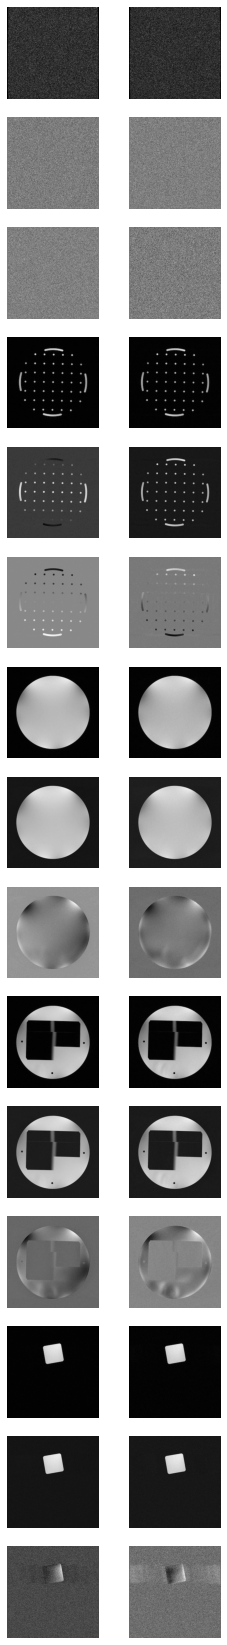

In [19]:
print(dobjs[3].pixel_array.shape)
fig, axs = plt.subplots(15, 2, figsize=(4, 30))
images = dobjs[3].pixel_array[sorting_indices]
print(images.shape)
for image, ax in zip(images, axs.flat):
    ax.imshow(image, cmap='gray')
    ax.grid(False)
    ax.axis('off')

Need to identify the dimensions of the multiframe. The 'shape' seems to be [1, 5, 3, 2].

If we define a sort order of the slices 

In [20]:
complexcomp = [fg.MRImageFrameTypeSequence[0].ComplexImageComponent for fg in dobjs[3].PerFrameFunctionalGroupsSequence]

print(complexcomp)

#len(list(dobjs[3].PerframeFunctionalGroups))

['IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'IMAGINARY', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'MAGNITUDE', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL', 'REAL']


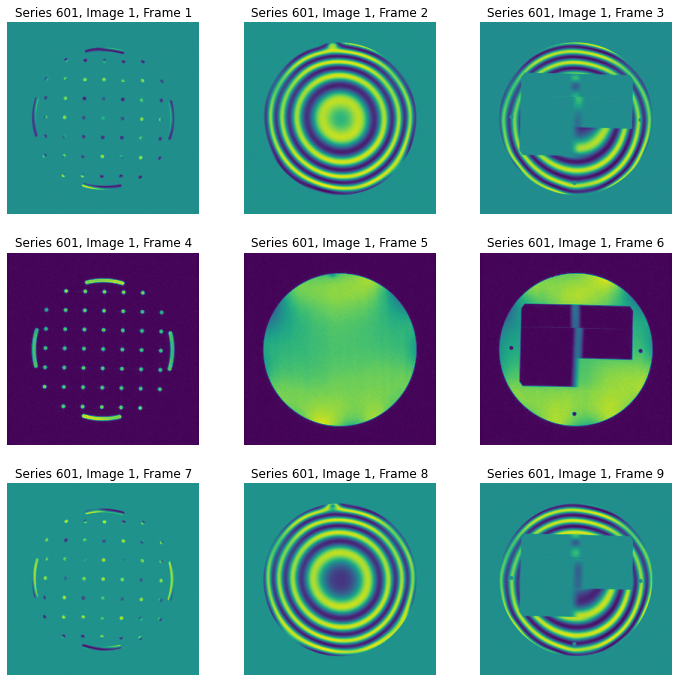

In [21]:
show_mosaic(dobjs[4:5], cmap='viridis')

In [22]:
complexcomp = [fg.MRImageFrameTypeSequence[0].ComplexImageComponent for fg in dobjs[4].PerFrameFunctionalGroupsSequence]

positions = [fg.FrameContentSequence[0].InStackPositionNumber for fg in dobjs[4].PerFrameFunctionalGroupsSequence]

pprint(list(zip(complexcomp, positions)))

[('IMAGINARY', 1),
 ('IMAGINARY', 2),
 ('IMAGINARY', 3),
 ('MAGNITUDE', 1),
 ('MAGNITUDE', 2),
 ('MAGNITUDE', 3),
 ('REAL', 1),
 ('REAL', 2),
 ('REAL', 3)]


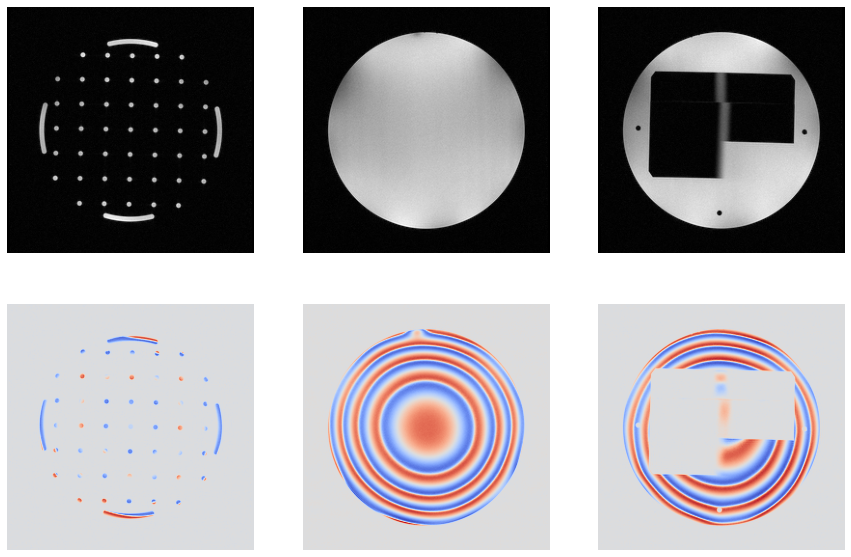

In [23]:
images = dobjs[4].pixel_array
phases = np.arctan2(images[:3],  images[6:9])
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for image, ax in zip(images[3:6], axs[0]):
    ax.imshow(image, cmap='gray')
    ax.grid(False)
    ax.axis('off')
    
for image, ax in zip(phases, axs[1]):
    ax.imshow(image, cmap='coolwarm')
    ax.grid(False)
    ax.axis('off')



1.5707964


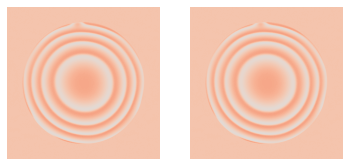

In [24]:
fig, axs = plt.subplots(1, 2)
print(np.ptp(phases[1]))
for image, ax in zip([phases[1], np.unwrap(phases[1])], axs):
    ax.imshow(image, cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    ax.grid(False)
    ax.axis('off')

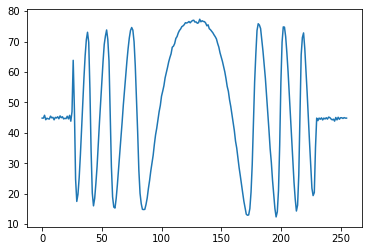

In [25]:
unif_phases = phases[1]
n_unif_phases = len(unif_phases)
plt.plot(180/np.pi * phases[1][n_unif_phases//2]);

In [26]:
dobjs[4].PerFrameFunctionalGroupsSequence[8]

(0018, 9114)  MR Echo Sequence  1 item(s) ---- 
   (0018, 9082) Effective Echo Time                 FD: 15.001
   ---------
(0018, 9152)  MR Metabolite Map Sequence  1 item(s) ---- 
   (0018, 9080) Metabolite Map Description          ST: 'WATER'
   ---------
(0018, 9226)  MR Image Frame Type Sequence  1 item(s) ---- 
   (0008, 9007) Frame Type                          CS: ['ORIGINAL', 'PRIMARY', 'T1', 'R']
   (0008, 9205) Pixel Presentation                  CS: 'MONOCHROME'
   (0008, 9206) Volumetric Properties               CS: 'VOLUME'
   (0008, 9207) Volume Based Calculation Technique  CS: 'NONE'
   (0008, 9208) Complex Image Component             CS: 'REAL'
   (0008, 9209) Acquisition Contrast                CS: 'T1'
   ---------
(0020, 9111)  Frame Content Sequence  1 item(s) ---- 
   (0018, 9074) Frame Acquisition DateTime          DT: '20170130164821.87'
   (0018, 9151) Frame Reference DateTime            DT: '20170130164813.13000'
   (0018, 9220) Frame Acquisition Duration     

In [27]:
dobjs[4].SharedFunctionalGroupsSequence[0]

(0018, 9006)  MR Imaging Modifier Sequence  1 item(s) ---- 
   (0018, 0095) Pixel Bandwidth                     DS: '361.689819335937'
   (0018, 9020) Magnetization Transfer              CS: 'NONE'
   (0018, 9022) Blood Signal Nulling                CS: 'NO'
   (0018, 9028) Tagging                             CS: 'NONE'
   (0018, 9098) Transmitter Frequency               FD: 127.742496
   ---------
(0018, 9042)  MR Receive Coil Sequence  1 item(s) ---- 
   (0018, 1250) Receive Coil Name                   SH: 'MULTI COIL'
   (0018, 9041) Receive Coil Manufacturer Name      LO: ''
   (0018, 9043) Receive Coil Type                   CS: 'MULTICOIL'
   (0018, 9044) Quadrature Receive Coil             CS: 'NO'
   (0018, 9045)  Multi-Coil Definition Sequence  1 item(s) ---- 
      (0018, 9047) Multi-Coil Element Name             SH: 'MULTI ELEMENT'
      (0018, 9048) Multi-Coil Element Used             CS: 'YES'
      ---------
   ---------
(0018, 9049)  MR Transmit Coil Sequence  1 item(s) 

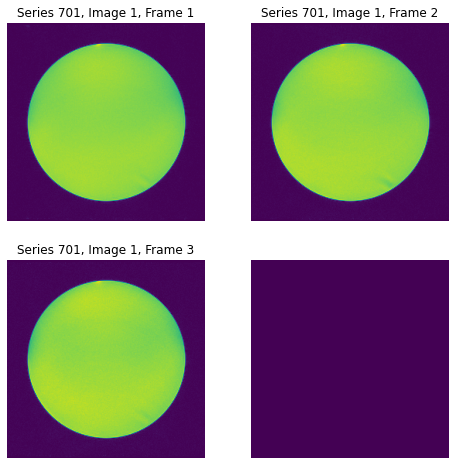

In [28]:
show_mosaic(dobjs[5:6], cmap='viridis')

So we seem to have 3 slightly mangled localisers, an axial stack of a structured phantom, what looks like some sort of field mapping, and three frames of an apparently uniform field. 

In [29]:
nreservnalloc = 12
print(0xffff >> (16 - 12))
print(2 ** 16 - 1)

4095
65535


In [30]:
import xarray as xr
from itertools import takewhile

def pixel_ndarray(dobj, squeeze=False):
    '''
    Image data from a (multiframe) DICOM object as a multidimensional numpy array
    
    Handles both multiframes and traditional single slice DICOM objects.
    
    Philips multiframes typically have one or more leading singleton dimensions.
    Setting the squeeze parameter eliminates these.
    

    Parameters
    ----------
    dobj: pydicom DICOM object
        DICOM object to extract images from.

    squeeze: bool
        whether to squeeze out singleton dimensions

    Returns
    -------
        numpy.ndarray
    '''

    if 'NumberOfFrames' not in dobj:
        # Only a single frame image - not a multiframe
        return dobj.pixel_array

    # Get the multiframe image stack (in frame order)
    multiframe = dobj.pixel_array
    nframes, ny, nx = multiframe.shape
    assert nframes == dobj.NumberOfFrames

    # The index values for each component of the multiframe
    frame_indices = [fg.FrameContentSequence[0].DimensionIndexValues for fg in dobj.PerFrameFunctionalGroupsSequence]
    
    # The range of values of each of the indices
    index_values = [sorted(set(col)) for col in np.asarray(frame_indices).T]
    
    # The implied shape of the corresponding array of images
    shape = tuple(map(len, index_values))
    assert np.prod(shape) == nframes
    
    # Sort the images according to their indices because they are not in general presented in index order
    sorting_indices = sorted(range(len(frame_indices)), key=lambda i: frame_indices[i])

    # and we can then reshape into a multidimensional numpy array
    ndimage = multiframe[sorting_indices].reshape(shape + (ny, nx))
    
    if squeeze:
        leading_singletons = tuple(
            i for i, _ in enumerate(takewhile(lambda x: x == 1, ndimage.shape))
        )
        return np.squeeze(ndimage, axis=leading_singletons)
    else:
        return ndimage


def pixel_xarray(dobj):
    '''
    Image data from a (multiframe) DICOM object as a multidimensional xarray DataArray
    
    Handles both multiframes and traditional single slice DICOM objects. The dimension names an
    structured indices on each dimension are determined by the multiframe description.

    Parameters
    ----------
    dobj: pydicom DICOM object
        DICOM object to extract images from.

    Returns
    -------
        xarray.DataArray
    '''

    if 'NumberOfFrames' not in dobj:
        # Only a single frame image - not a multiframe
        return xr.DataArray(data=dobj.pixel_array, dims=['y',  'x'])


    # Get the multiframe image stack (in frame order)
    multiframe = dobj.pixel_array
    nframes, ny, nx = multiframe.shape
    assert nframes == int(dobj.NumberOfFrames)

    #
    # Deduce the true shape of the multiframe and reshape the pixel array accordingly
    #

    # The index values for each component of the multiframe
    frame_indices = [fg.FrameContentSequence[0].DimensionIndexValues for fg in dobj.PerFrameFunctionalGroupsSequence]
    # The range of values of each of the indices
    index_values = [sorted(set(col)) for col in np.asarray(frame_indices).T]
    # The implied shape of the corresponding array of images
    shape = tuple(map(len, index_values))
    assert np.prod(shape) == nframes
    
    # Sort the images according to their indices because they are not in general presented in index order
    sorting_indices = sorted(range(len(frame_indices)), key=lambda i: frame_indices[i])
    # and we can then reshape into a multidimensional numpy array
    ndimage = multiframe[sorting_indices].reshape(shape + (ny, nx))
    
    #
    # Construct meaningful indices for the coordinates of the multidimensional array
    #

    # Dimension names for xarray Dataarray constructor
    dims = [ind.DimensionDescriptionLabel for ind in dobj.DimensionIndexSequence] + ['y', 'x']
    
    # Basic indices for xarray Dataarray constructor

    # The range of values of each of the indices
    index_lists =  index_values + [list(range(ny)), list(range(nx))]

    # Construct mapping from the basic indices to values of coordinates so we
    # can put meaningful coordinate values into Dataarray axes
    # for each 'axis' fgroup and dindex say where to look for the 'value' in
    # the PerframeFunctionalGroup Sequence.
    fgroups = [dindex.FunctionalGroupPointer for dindex in dobj.DimensionIndexSequence]
    dindices = [dindex.DimensionIndexPointer for dindex in dobj.DimensionIndexSequence]
    label_values = [
        [pffg[fgroup][0][dindex].value for fgroup, dindex in zip(fgroups, dindices)]
        for pffg in dobj.PerFrameFunctionalGroupsSequence
    ]

    # build mapping by looking at all the correspondences between indices and values.
    index2label_maps = [{} for _ in range(len(frame_indices[0]))]
    for frame_index, label_value in zip(frame_indices, label_values):
        for i, (index, label) in enumerate(zip(frame_index, label_value)):
            index2label_maps[i][index] = label
    
    # add just the identity mapping for the pixel coordinates
    y_range = list(range(ny))
    x_range = list(range(nx))
    index2label_maps += [
        dict(zip(y_range, y_range)), dict(zip(x_range, x_range))
    ]
    
    # xarray coords will now be the values of the coordinates at each index position
    # we could have used just the simple indices and have the index to coordinate value mapping
    # represented elsewhere but it's not clear where exactly.
    # we pass the coordinate indices through the mapping.
    coords = [
        [index2label_map[k] for k in index_list]
        for index_list, index2label_map in zip(index_lists, index2label_maps)
    ]
    # note that we've not resolved the positional coordinates right down to their real space
    # values in mm but still just have nominal indices for these. We could do this based on 
    # the slice location and pixel dimensions (or better still using the image position tags)
    # but maybe this additional mapping would be better done in attributes of some kind.
    # we could also add attributes for the image orientation. However, we would need to validate
    # that the multiframe really does form a coherent stack (same dimension uid, same for uid, image positions
    # lie evenly spaced along a line orthogonal to the imaging plane) 
    
    
    #print('Index2Label Mapping:', index2label_maps[:-2])
    #print('Index Values', index_values)
    #print('Label Values', label_values)
    #print('Orig Image Shape:', image.shape)
    #print('Indices to Sort Stack:', sorting_indices)
    #print('Coords:', coords)
    #print('Dims:', dims)
    #print('Final Image Shape:', image.shape)
    
    return xr.DataArray(data=ndimage, coords=coords, dims=dims)

(-0.5, 255.5, 255.5, -0.5)

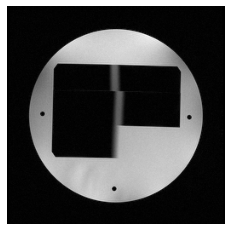

In [31]:
imagearray = pixel_xarray(dobjs[3])
plt.imshow(imagearray.loc['1', 4, 'M', 100.0, :, :], cmap='gray')
plt.grid(False)
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

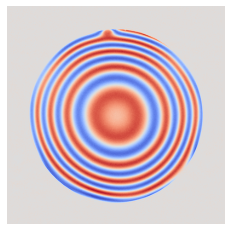

In [32]:
imagearray = pixel_xarray(dobjs[4])
plt.imshow(imagearray.loc['1', 2, 'I', :, :], cmap='coolwarm')
plt.grid(False)
plt.axis('off')

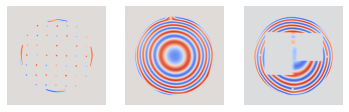

In [33]:
realimages = imagearray.loc['1', :, 'R', :, :]
fig, axs = plt.subplots(1, len(realimages))
for ax, image in zip(axs, realimages):
    ax.imshow(image, cmap='coolwarm')
    ax.grid(False)
    ax.axis('off')


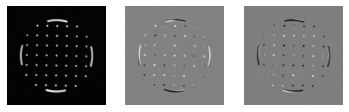

In [34]:
sliceimages = imagearray.loc['1', 1, :, :, :]
fig, axs = plt.subplots(1, len(sliceimages))
for ax, image in zip(axs, sliceimages):
    ax.imshow(image, cmap='gray')
    ax.grid(False)
    ax.axis('off')

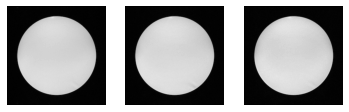

In [35]:
imagearray = pixel_xarray(dobjs[5]).loc['1', 1]
fig, axs = plt.subplots(1, len(imagearray))
for ax, image in zip(axs, imagearray):
    ax.imshow(image, cmap='gray')
    ax.grid(False)
    ax.axis('off')

In [36]:
print(pixel_ndarray(dobjs[5]).shape)
print(pixel_ndarray(dobjs[5], True).shape)
fgroups = [dindex.FunctionalGroupPointer for dindex in dobjs[3].DimensionIndexSequence]
dindices = [dindex.DimensionIndexPointer for dindex in dobjs[3].DimensionIndexSequence]

(1, 1, 3, 256, 256)
(3, 256, 256)


In [37]:
for fgroup, dindex in zip(fgroups, dindices):
    print(dobjs[3].PerFrameFunctionalGroupsSequence[0][fgroup][0][dindex])

(0020, 9056) Stack ID                            SH: '1'
(0020, 9057) In-Stack Position Number            UL: 1
(2005, 1011) [ImageType]                         CS: 'I'
(0018, 9082) Effective Echo Time                 FD: 30.0


In [38]:
print([
    pffg[fgroup][0][dindex].value
    for pffg in dobjs[3].PerFrameFunctionalGroupsSequence
    for fgroup, dindex in zip(fgroups, dindices)
])


['1', 1, 'I', 30.0, '1', 1, 'I', 100.0, '1', 2, 'I', 30.0, '1', 2, 'I', 100.0, '1', 3, 'I', 30.0, '1', 3, 'I', 100.0, '1', 4, 'I', 30.0, '1', 4, 'I', 100.0, '1', 5, 'I', 30.0, '1', 5, 'I', 100.0, '1', 1, 'M', 30.0, '1', 1, 'M', 100.0, '1', 2, 'M', 30.0, '1', 2, 'M', 100.0, '1', 3, 'M', 30.0, '1', 3, 'M', 100.0, '1', 4, 'M', 30.0, '1', 4, 'M', 100.0, '1', 5, 'M', 30.0, '1', 5, 'M', 100.0, '1', 1, 'R', 30.0, '1', 1, 'R', 100.0, '1', 2, 'R', 30.0, '1', 2, 'R', 100.0, '1', 3, 'R', 30.0, '1', 3, 'R', 100.0, '1', 4, 'R', 30.0, '1', 4, 'R', 100.0, '1', 5, 'R', 30.0, '1', 5, 'R', 100.0]


### To Do
Sort out image masking (bits stored etc) and imaging scaling (slope intercept etc)  in the context of multiframes. NB the latter will probably imply a conversion of the whole array to float if at least some of it is rescaled.